#### Dependencies

In [1]:
import numpy as np
import csv
import os
import sys  # Import the sys module
import time
from functools import partial
from multiprocessing import Pool, cpu_count
from scipy.optimize import differential_evolution

sys.path.append('..')
from dataset_reader import Traces_Dataset
from DE_obj_model import de_obj_model   
from exp_hh_model import HH_model_exp

#### Read test dataset

In [2]:
dataset = Traces_Dataset('../dataset_test.csv')

params = dataset.params.numpy()
current_traces = dataset.current_traces.numpy()
time_traces = dataset.time_traces.numpy()

sample = 32
prestep_V_2d = dataset.prestep_V[sample].numpy().reshape(-1,1)
step_Vs_2d = dataset.step_Vs[sample].numpy().reshape(-1,1)
t = time_traces[sample]

target_traces = current_traces[sample]
target_params = params[sample]

In [3]:
# sim setup for obj evaluation model
sim_setup_2d = {'prestep_V': prestep_V_2d, 'step_Vs': step_Vs_2d, 't': t}
# sim_setup_2d
# model = de_obj_model(target_params, sim_setup_2d)

In [ ]:
# sim_traces = model.simulation()
# sim_traces.shape

#### Plotting function for trail, target, and real data

In [20]:
def plot_trail_target_real(sim_setup_1d, t, sim_traces, target_traces, target_params): 
    '''
    sim_setup_1d is the exp setup for hh model, all default as in hh class
    t is the target time traces from generated dataset
    sim_traces is the generated during searching stage
    target_traces is the target current traces from the generated dataset
    target_params is the target params from the generated dataset, dict
    '''
    # compare samples and simulations using sample params
    hh_model = HH_model_exp(target_params, sim_setup_1d)
    current_traces_sim = hh_model.simulation()

    colors = ['blue', 'red', 'green', 'purple', 'orange', 'yellow', 'cyan', 'magenta', 'brown', 'gray', 'black']

    for step in range(t.shape[0]): 
        plt.plot(t[step], sim_traces[step], linestyle='-', color=colors[step])
        plt.plot(t[step], target_traces[step], linestyle=':', color=colors[step])
        plt.plot(sim_setup_1d['t'], current_traces_sim[step], linestyle='--', color=colors[step])
    plt.legend()
    plt.title(f"prestep_V: {sim_setup_1d['prestep_V']}; step_V1: {sim_setup_1d['step_Vs'][0]}")


In [21]:
# sim setup for plotting real data
sim_setup_1d = {'prestep_V': np.squeeze(prestep_V_2d), 'step_Vs': np.squeeze(step_Vs_2d), 't': np.arange(0.0, 6.0, 0.01)}
target_params_dict = {'p': target_params[0], 'g_max': target_params[1], 'E_rev': target_params[2], 'a_m': target_params[3], 'b_m': target_params[4], 'delta_m': target_params[5], 's_m': target_params[6]}
plot_trail_target_real(sim_setup_1d, t, sim_traces, target_traces, target_params_dict)

NameError: name 'sim_traces' is not defined

#### Define obj function

In [4]:
def obj(x, *args): 
    '''
    x: a 1-D array of the variables for the obj function (the parameters we are estimating)
    args: a tupleo f additional fixed parameters (prestep_V, step_V0, time_traces)
    *args=(sim_setup_2d, target_current_trances)
    '''
    trail_model = de_obj_model(x, args[0])
    trail_traces = trail_model.simulation()
    # print(trail_traces[1])
    target_model = de_obj_model(args[1], args[0])
    target_traces = target_model.simulation()
    # print(target_traces[1]) 

    fit = np.sum(np.square(trail_traces - target_traces))
    # relative_error = fit/np.sum(np.square(target_traces))
    
    return fit


In [5]:
fitness = obj(params[32], *(sim_setup_2d, target_params))
print(fitness)

0.0


#### Define bounds

In [6]:
# these bounds are from the distribution of the params in the dataset used for NN training
params_searching_bounds = {
    'p': (1, 4),
    'g_max': (100, 140), 
    'E_rev': (-100, -60), 
    'a_m': (0, 100), 
    'b_m': (0, 100), 
    'delta_m': (0, 1), 
    's_m': (-100, 0)
}
bounds = [params_searching_bounds['p'], params_searching_bounds['g_max'], params_searching_bounds['E_rev'], params_searching_bounds['a_m'], params_searching_bounds['b_m'], params_searching_bounds['delta_m'], params_searching_bounds['s_m']]

In [7]:
# def callback_function(xk, convergence):
#     callback_function.iteration += 1
#     print("Iteration:", callback_function.iteration)
#     print("Solution:", xk)
#     print("Objective value:", obj(xk, sim_setup_2d, target_params))
#     print("------------------------")
# callback_function.iteration = 0  # Initialize the iteration counter

In [8]:
results_iter = []

def callback(xk, convergence):
    results_iter.append(xk)

In [9]:
from scipy.optimize import differential_evolution

result = differential_evolution(obj, bounds, args=(sim_setup_2d, target_params), strategy='randtobest1bin', popsize=105, mutation=(0.1,0.9), recombination=0.9, seed=42, maxiter=300, tol=-1, disp=True, callback=callback)

/Users/maxwellyue/Documents/GitHub/Compute-Canada-Research/Exp_rates_generalized_exp_setup/DE/DE_obj_model.py:33: RuntimeWarning: overflow encountered in exp
  return (1 / (1 + np.exp((V - self.V_2m) / self.s_m))).reshape((-1,1))
/Users/maxwellyue/Documents/GitHub/Compute-Canada-Research/Exp_rates_generalized_exp_setup/DE/DE_obj_model.py:42: RuntimeWarning: overflow encountered in exp
  return ((tau_0m * np.exp(self.delta_m * ((V - self.V_2m) / self.s_m))) / (1 + np.exp((V - self.V_2m) / self.s_m))).reshape((-1,1))
/Users/maxwellyue/Documents/GitHub/Compute-Canada-Research/Exp_rates_generalized_exp_setup/DE/DE_obj_model.py:63: RuntimeWarning: divide by zero encountered in divide
  return self.m_infty(V) + (self.m_infty(self.prestep_V) - self.m_infty(V)) * np.exp(- self.t / self.tau_m(V))
/Users/maxwellyue/Documents/GitHub/Compute-Canada-Research/Exp_rates_generalized_exp_setup/DE/DE_obj_model.py:63: RuntimeWarning: invalid value encountered in divide
  return self.m_infty(V) + (self.m_

differential_evolution step 1: f(x)= 1.62884e+08
differential_evolution step 2: f(x)= 8.65569e+07
differential_evolution step 3: f(x)= 8.65569e+07
differential_evolution step 4: f(x)= 8.65569e+07
differential_evolution step 5: f(x)= 8.65569e+07
differential_evolution step 6: f(x)= 8.65569e+07
differential_evolution step 7: f(x)= 8.65569e+07
differential_evolution step 8: f(x)= 8.30226e+07
differential_evolution step 9: f(x)= 5.96954e+07
differential_evolution step 10: f(x)= 4.22439e+07
differential_evolution step 11: f(x)= 2.79515e+07
differential_evolution step 12: f(x)= 2.45272e+07
differential_evolution step 13: f(x)= 2.45272e+07
differential_evolution step 14: f(x)= 2.32243e+07
differential_evolution step 15: f(x)= 2.32243e+07
differential_evolution step 16: f(x)= 1.87998e+07
differential_evolution step 17: f(x)= 1.87998e+07
differential_evolution step 18: f(x)= 1.82078e+07
differential_evolution step 19: f(x)= 1.31705e+07
differential_evolution step 20: f(x)= 1.31705e+07
different

In [10]:
target_params, result.x

(array([  4.        , 117.62001   , -91.75146   ,   3.0627584 ,
          2.1278825 ,   0.97711813, -10.904842  ], dtype=float32),
 array([  3.99999953, 117.61793077, -91.75391299,   3.06275196,
          2.12789006,   0.97712092, -10.90486673]))

In [11]:
(target_params - result.x) ** 2

array([2.17882823e-13, 4.32474344e-06, 6.03081265e-06, 4.21121952e-11,
       5.75017530e-11, 7.77428228e-12, 5.93276909e-10])

In [12]:
np.mean((target_params - result.x) ** 2)

1.4794652807026511e-06

In [13]:
result.x

array([  3.99999953, 117.61793077, -91.75391299,   3.06275196,
         2.12789006,   0.97712092, -10.90486673])

In [14]:
result

 message: Maximum number of iterations has been exceeded.
 success: False
     fun: 1.9728416800213716e-05
       x: [ 4.000e+00  1.176e+02 -9.175e+01  3.063e+00  2.128e+00
            9.771e-01 -1.090e+01]
     nit: 300
    nfev: 221267
     jac: [ 6.317e-01 -5.415e-04  3.501e-03  0.000e+00  0.000e+00
            0.000e+00  0.000e+00]

#### DE results on dotty plots

In [15]:
results_iter = np.array(results_iter)

p_iter = results_iter[:,0]
g_max_inter = results_iter[:,1]
E_rev_iter = results_iter[:,2]
a_m_iter = results_iter[:,3]
b_m_iter = results_iter[:,4]
delta_m_iter = results_iter[:,5]
s_m_iter = results_iter[:,6]

In [16]:
t = np.arange(0.0, 6.0, 0.01)
prestep_V_32 = int(prestep_V_2d.reshape(-1))
step_Vs_32 = step_Vs_2d.reshape(-1)
# prestep_V_32, step_Vs_32, t

In [27]:
def obj_trace(current_traces, max_ind_arrs, target_current_traces, target_max_ind_arr, trace):
    '''
    find the area difference in the rising phase instead of the whole simulation. 
    This can be done by defining a window using the earlier threshold between two sample traces. 
    the fct is comparing two traces from the same experiment in two different samples. 
    '''
    # find the earlier threshold index + 1. 
    stop_ind = int(min(max_ind_arrs[trace], target_max_ind_arr[trace]))
    #print(sample1, sample2, trace)
    #print(np.where(selected_t[sample1, trace] == -1)[0][0], np.where(selected_t[sample2, trace] == -1)[0][0])
    # we calculate the (avg over stop_ind points) 

    # diff_area_one_trace = np.trapz(np.abs(selected_current_traces_3d[sample1, trace, :stop_ind] - selected_current_traces_3d[sample2, trace, :stop_ind]), dataset_generator.t[:stop_ind]) / np.trapz(np.maximum(selected_current_traces_3d[sample1, trace, :stop_ind], selected_current_traces_3d[sample2, trace, :stop_ind]), dataset_generator.t[:stop_ind])
    diff_area_one_trace = np.trapz(np.abs(current_traces[trace, :stop_ind] - target_current_traces[trace, :stop_ind]), t[:stop_ind]) / np.trapz(np.maximum(current_traces[trace, :stop_ind], target_current_traces[trace, :stop_ind]), t[:stop_ind])
    return diff_area_one_trace

def obj(current_traces, max_ind_arrs, target_current_traces, target_max_ind_arr): 
    diff_area = np.mean([obj_trace(current_traces, max_ind_arrs, target_current_traces, target_max_ind_arr, trace) for trace in range(target_current_traces.shape[0])])
    # diff_params_square = np.sum(np.square(selected_params[sample1] - selected_params[sample2]))
    return diff_area #, diff_params_square

def dotty_plot_obj_given_params(params, target_params):
    # params is a np array of the parameters
    sim_setup = {'t':t, 'prestep_V':prestep_V_32, 'step_Vs':step_Vs_32}
    
    params_dict = {'p': params[0], 'g_max': params[1], 'E_rev': params[2], 'a_m': params[3], 'b_m': params[4], 'delta_m': params[5], 's_m': params[6]}
    target_params_dict = {'p': target_params[0], 'g_max': target_params[1], 'E_rev': target_params[2], 'a_m': target_params[3], 'b_m': target_params[4], 'delta_m': target_params[5], 's_m': target_params[6]}
    
    model = HH_model_exp(params_dict, sim_setup)
    model.simulation()
    target_model = HH_model_exp(target_params_dict, sim_setup)
    target_model.simulation()

    if target_model.check_current_ss():
        target_max_index_arr = target_model.max_index_array
        if model.check_current_ss(): 
            max_index_arr = model.max_index_array
        else:
            max_index_arr = target_max_index_arr
            print('Trail failed reach threshold !!')
    else:
        print('Target fails to reach threshold !!')
    return obj(model.current_traces, model.max_index_array, target_model.current_traces, target_model.max_index_array)
    
# dotty_plot_obj_given_params(results_iter[0], target_params)

In [32]:
dotty_objs = []
for xk in results_iter:
    dotty_objs.append(dotty_plot_obj_given_params(xk, target_params))

len(dotty_objs)

Trail failed reach threshold !!
Trail failed reach threshold !!
Trail failed reach threshold !!
Trail failed reach threshold !!
Trail failed reach threshold !!
Trail failed reach threshold !!
Trail failed reach threshold !!
Trail failed reach threshold !!
Trail failed reach threshold !!
Trail failed reach threshold !!
Trail failed reach threshold !!
Trail failed reach threshold !!
Trail failed reach threshold !!
Trail failed reach threshold !!
Trail failed reach threshold !!
Trail failed reach threshold !!
Trail failed reach threshold !!
Trail failed reach threshold !!
Trail failed reach threshold !!
Trail failed reach threshold !!
Trail failed reach threshold !!


/var/folders/7_/yd2c8wld3sggx9gtmv9ydwm80000gn/T/ipykernel_44422/3629529091.py:14: RuntimeWarning: invalid value encountered in double_scalars
  diff_area_one_trace = np.trapz(np.abs(current_traces[trace, :stop_ind] - target_current_traces[trace, :stop_ind]), t[:stop_ind]) / np.trapz(np.maximum(current_traces[trace, :stop_ind], target_current_traces[trace, :stop_ind]), t[:stop_ind])


300

In [34]:
import numpy as np 
import matplotlib.pyplot as plt

params_list1 = np.load('../Identifiability/param_lists_on_32_30000samples.npy')
params_list2 = np.load('../Identifiability/param_lists_on_32_50000samples.npy')
params_list3 = np.load('../Identifiability/param_lists_on_32_60000samples.npy')
params_list4 = np.load('../Identifiability/param_lists_on_32_40000samples.npy')

fitness_list1 = np.load('../Identifiability/fitness_list_on_32_30000samples.npy')
fitness_list2 = np.load('../Identifiability/fitness_list_on_32_50000samples.npy')
fitness_list3 = np.load('../Identifiability/fitness_list_on_32_60000samples.npy')
fitness_list4 = np.load('../Identifiability/fitness_list_on_32_40000samples.npy')

combined_params_list = np.concatenate((params_list1, params_list2, params_list3, params_list4), axis=1)
combined_fitness_list = np.concatenate((fitness_list1, fitness_list2, fitness_list3, fitness_list4), axis=0)

In [35]:
# # get target
# import sys
# sys.path.append('..')
# from dataset_reader import Traces_Dataset

# dataset = Traces_Dataset('../dataset_test.csv')
# target_num = 32
# target_params = dataset.params[target_num].numpy()

# params = {'p': target_params[0], 
#           'g_max': target_params[1], 
#           'E_rev': target_params[2], 
#                  'a_m': target_params[3], 
#                  'b_m': target_params[4], 
#                  'delta_m': target_params[5], 
#                  's_m': target_params[6]}
# params_names = list(params.keys())

In [36]:
dotty_objs_arr = np.array(dotty_objs)
# Find the indices of NaN values
nan_indices = np.where(np.isnan(dotty_objs))[0]
print(nan_indices)

dotty_objs_arr = np.delete(dotty_objs_arr, nan_indices)
valid_dotty_objs = np.delete(dotty_objs, nan_indices)
valid_dotty_objs.shape

[ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17]


(284,)

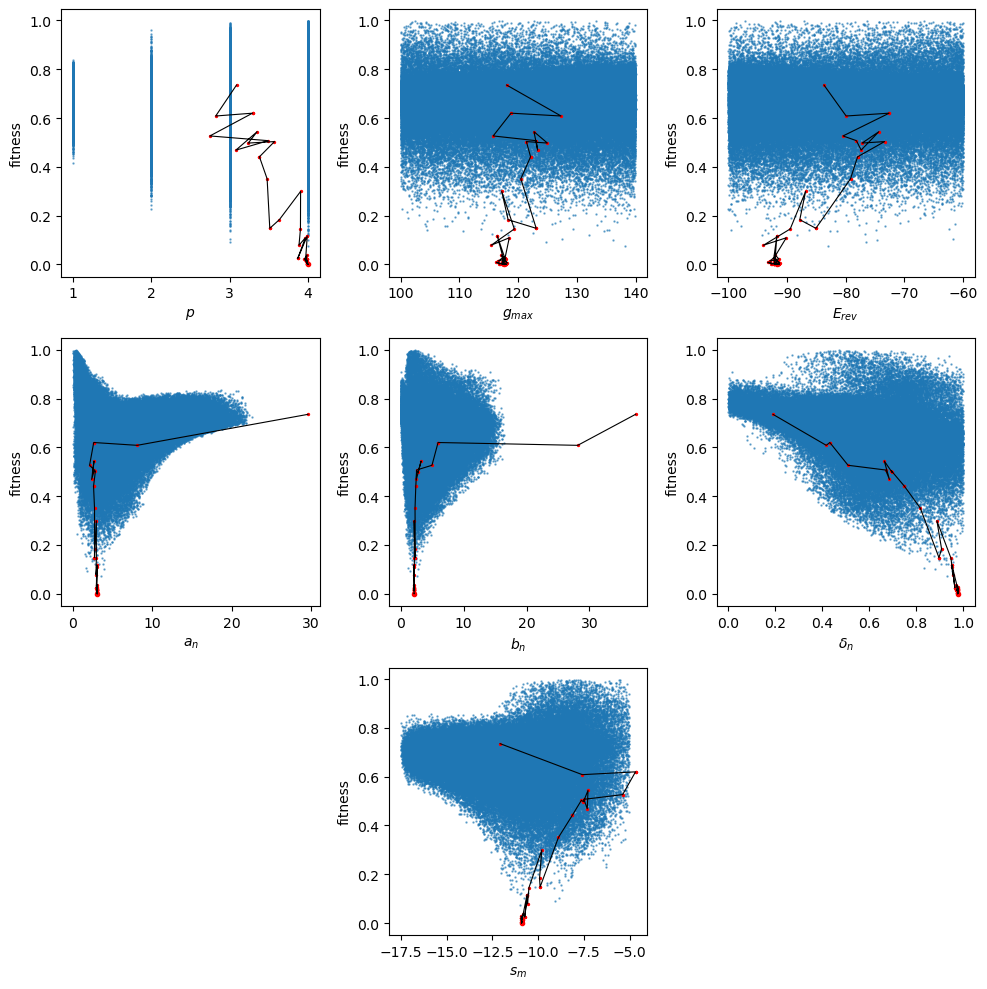

In [37]:
# Create a 3x3 grid of subplots
fig, axs = plt.subplots(3, 3, figsize=(10, 10))
params_names = ['$p$', '$g_{max}$', '$E_{rev}$', '$a_n$', '$b_n$', '$\\delta_n$', '$s_m$']

# Plot each subplot
for i in range(7):
    if i != 6:  # Skip the empty plot area
        axs[i // 3, i % 3].scatter(combined_params_list[i], combined_fitness_list, alpha=0.6, s=0.5)
        axs[i // 3, i % 3].plot(target_params[i], 0, 'ro', markersize=3)
        # plot params from DE optimization
        valid_trail_param = np.delete(results_iter[:,i], nan_indices)
        axs[i // 3, i % 3].plot(valid_trail_param, valid_dotty_objs, color='black', linewidth=0.8, linestyle='-')
        axs[i // 3, i % 3].scatter(valid_trail_param, valid_dotty_objs, color='red', marker='o', s=2)
        axs[i // 3, i % 3].set_xlabel(params_names[i])  # Set x-label for each subplot
        axs[i // 3, i % 3].set_ylabel('fitness')
        # axs[i // 3, i % 3].set_title(f'Plot {i+1}')
    else:
        axs[2, 1].scatter(combined_params_list[6], combined_fitness_list, alpha=0.6, s=0.5)
        axs[2, 1].plot(target_params[6], 0, 'ro', markersize=3)
        # plot params from DE optimization
        valid_trail_param = np.delete(results_iter[:,6], nan_indices)
        axs[2, 1].plot(valid_trail_param, valid_dotty_objs, color='black', linewidth=0.8, linestyle='-')
        axs[2, 1].scatter(valid_trail_param, valid_dotty_objs, color='red', marker='o', s=2)
        axs[2, 1].set_xlabel(params_names[6])
        axs[2, 1].set_ylabel('fitness')

# Remove the empty plot area
fig.delaxes(axs[2, 0])
fig.delaxes(axs[2, 2])

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

### test on all samples

In [3]:
dataset = Traces_Dataset('../dataset_test.csv')

params = dataset.params.numpy()
current_traces = dataset.current_traces.numpy()
time_traces = dataset.time_traces.numpy()

prestep_V_vec = dataset.prestep_V.numpy()
step_Vs_vec = dataset.step_Vs.numpy()

In [4]:
def obj(x, *args): 
    '''
    x: a 1-D array of the variables for the obj function (the parameters we are estimating)
    *args=(sim_setup_2d, target_current_trances)
    '''
    trail_model = de_obj_model(x, args[0])
    trail_traces = trail_model.simulation()
    # print(trail_traces[1])
    target_model = de_obj_model(args[1], args[0])
    target_traces = target_model.simulation()
    # print(target_traces[1]) 

    fit = np.sum(np.square(trail_traces - target_traces))
    # relative_error = fit/np.sum(np.square(target_traces))
    
    return fit

In [5]:
# these bounds are from the distribution of the params in the dataset used for NN training
params_searching_bounds = {
    'p': (1, 4),
    'g_max': (100, 140), 
    'E_rev': (-100, -60), 
    'a_m': (0, 100), 
    'b_m': (0, 100), 
    'delta_m': (0, 1), 
    's_m': (-100, 0)
}
bounds = [params_searching_bounds['p'], params_searching_bounds['g_max'], params_searching_bounds['E_rev'], params_searching_bounds['a_m'], params_searching_bounds['b_m'], params_searching_bounds['delta_m'], params_searching_bounds['s_m']]

In [ ]:
mse_list = []
time_list = []

for sample in range(10):
    print(f'{sample}: \n')               
    prestep_V_2d = prestep_V_vec[sample].reshape(-1,1)
    step_Vs_2d = step_Vs_vec[sample].reshape(-1,1)
    t = time_traces[sample]

    # prestep_V_2d = dataset.prestep_V[sample].numpy().reshape(-1,1)
    # step_Vs_2d = dataset.step_Vs[sample].numpy().reshape(-1,1)
    # t = time_traces[sample]

    # target_traces = current_traces[sample]
    target_params = params[sample]

    # sim setup for obj evaluation model
    sim_setup_2d = {'prestep_V': prestep_V_2d, 'step_Vs': step_Vs_2d, 't': t}   

    start_time = time.time()
    result = differential_evolution(obj, bounds, args=(sim_setup_2d, target_params), seed=42, maxiter=300, disp=True)
    end_time = time.time()

    print(target_params, result.x)

    mse = (target_params - result.x) ** 2
    mse_list.append(mse)
    elapsed_time = end_time - start_time
    time_list.append(elapsed_time)

mse_mat = np.vstack(mse_list)
time_mat = np.array(time_list).reshape(-1, 1)

mse_overall_avg = np.mean(mse_mat)
mse_overall_std = np.std(np.mean(mse_mat, axis=1))
time_overall_avg = np.mean(time_mat)
time_overall_std = np.std(time_mat)

In [ ]:
mse_overall_avg

127.9836217441734

In [ ]:
target_params, result.x

(array([  4.       , 118.27517  , -71.81706  ,   2.0534372,  13.061292 ,
          0.1570644, -11.075991 ], dtype=float32),
 array([  3.99999708, 118.27580194, -71.81624795,   2.05343767,
         13.06131683,   0.1570641 , -11.07597521]))

### Hyperparameter Tuning

In [70]:
dataset = Traces_Dataset('../dataset_test.csv')

params = dataset.params.numpy()
# current_traces = dataset.current_traces.numpy()
time_traces = dataset.time_traces.numpy()

prestep_V_vec = dataset.prestep_V.numpy()
step_Vs_vec = dataset.step_Vs.numpy()

In [71]:
def obj(x, *args): 
    '''
    x: a 1-D array of the variables for the obj function (the parameters we are estimating)
    *args=(sim_setup_2d, target_current_trances)
    '''
    trail_model = de_obj_model(x, args[0])
    trail_traces = trail_model.simulation()
    # print(trail_traces[1])
    target_model = de_obj_model(args[1], args[0])
    target_traces = target_model.simulation()
    # print(target_traces[1]) 

    fit = np.sum(np.square(trail_traces - target_traces))
    # relative_error = fit/np.sum(np.square(target_traces))
    
    return fit

In [72]:
# these bounds are from the distribution of the params in the dataset used for NN training
params_searching_bounds = {
    'p': (1, 4),
    'g_max': (100, 140), 
    'E_rev': (-100, -60), 
    'a_m': (0, 100), 
    'b_m': (0, 100), 
    'delta_m': (0, 1), 
    's_m': (-100, 0)
}
bounds = [params_searching_bounds['p'], params_searching_bounds['g_max'], params_searching_bounds['E_rev'], params_searching_bounds['a_m'], params_searching_bounds['b_m'], params_searching_bounds['delta_m'], params_searching_bounds['s_m']]

In [73]:
hyperparameters_grid = {
    'strategy': ['best1bin', 'best1exp', 'rand1exp', 'rand1exp', 
                'rand2bin', 'rand2exp', 'best2bin', 'best2exp',
                'randtobest1bin', 'randtobest1exp',
                'currenttobest1bin', 'currenttobest1exp'],
    'popsize': [14,21,28,35,42,49,56,63,70],  # Example popsize hyperparameter
    'mutation': [(0.1, 0.9)],  # Example mutation hyperparameter
    'recombination': [0.9],  # Example recombination hyperparameter
    'init': ['latinhypercube'],  # Example init hyperparameter
}


In [74]:
#############################################################################
#using single samples to tune hyperparameters################################
#############################################################################
sample = 32

csv_filename = f'de_experiment_results_{sample}.csv'
# Define the headers for the CSV file
csv_headers = ['Strategy', 'Popsize', 'Mutation', 'Recombination', 'Init', 'MSE Overall', 'Elapsed Time']

# Check if the CSV file exists; if not, create and write the headers
if not os.path.exists(csv_filename):
    with open(csv_filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(csv_headers)

with open(csv_filename, mode='a', newline='') as file:
    writer = csv.writer(file)
    for strategy in hyperparameters_grid['strategy']:
        for popsize in hyperparameters_grid['popsize']:
            for mutation in hyperparameters_grid['mutation']:
                for recombination in hyperparameters_grid['recombination']:
                    for init in hyperparameters_grid['init']:

                        prestep_V_2d = prestep_V_vec[sample].reshape(-1,1)
                        step_Vs_2d = step_Vs_vec[sample].reshape(-1,1)
                        t = time_traces[sample]
                        # target_traces = current_traces[sample]
                        target_params = params[sample]

                        # sim setup for obj evaluation model
                        sim_setup_2d = {'prestep_V': prestep_V_2d, 'step_Vs': step_Vs_2d, 't': t}   

                        start_time = time.time()
                        result = differential_evolution(obj, bounds, args=(sim_setup_2d, target_params), strategy=strategy, popsize=popsize, mutation=mutation, recombination=recombination, init=init, seed=42, maxiter=1000, tol=-1)
                        end_time = time.time()
                    
                        mse = (target_params - result.x) ** 2
                        elapsed_time = end_time - start_time

                        mse_overall = np.mean(mse)
                        print(mse_overall)
                        
                        writer.writerow([strategy, popsize, mutation, recombination, init, mse_overall, elapsed_time])

/lustre06/project/6000803/maxwell8/Compute-Canada-Research/Exp_rates_generalized_exp_setup/DE/DE_obj_model.py:33: RuntimeWarning: overflow encountered in exp
  return (1 / (1 + np.exp((V - self.V_2m) / self.s_m))).reshape((-1,1))
/lustre06/project/6000803/maxwell8/Compute-Canada-Research/Exp_rates_generalized_exp_setup/DE/DE_obj_model.py:42: RuntimeWarning: overflow encountered in exp
  return ((tau_0m * np.exp(self.delta_m * ((V - self.V_2m) / self.s_m))) / (1 + np.exp((V - self.V_2m) / self.s_m))).reshape((-1,1))
/lustre06/project/6000803/maxwell8/Compute-Canada-Research/Exp_rates_generalized_exp_setup/DE/DE_obj_model.py:63: RuntimeWarning: divide by zero encountered in divide
  return self.m_infty(V) + (self.m_infty(self.prestep_V) - self.m_infty(V)) * np.exp(- self.t / self.tau_m(V))
/lustre06/project/6000803/maxwell8/Compute-Canada-Research/Exp_rates_generalized_exp_setup/DE/DE_obj_model.py:63: RuntimeWarning: invalid value encountered in divide
  return self.m_infty(V) + (self.m_

5.790645656876622e-06


/lustre06/project/6000803/maxwell8/Compute-Canada-Research/Exp_rates_generalized_exp_setup/DE/DE_obj_model.py:63: RuntimeWarning: overflow encountered in divide
  return self.m_infty(V) + (self.m_infty(self.prestep_V) - self.m_infty(V)) * np.exp(- self.t / self.tau_m(V))
/lustre06/project/6000803/maxwell8/Compute-Canada-Research/Exp_rates_generalized_exp_setup/DE/DE_obj_model.py:23: RuntimeWarning: divide by zero encountered in log
  self.V_2m = - self.s_m * np.log(self.b_m / self.a_m)
/lustre06/project/6000803/maxwell8/Compute-Canada-Research/Exp_rates_generalized_exp_setup/DE/DE_obj_model.py:41: RuntimeWarning: invalid value encountered in scalar multiply
  tau_0m = (1 / self.a_m) * np.exp((self.delta_m * self.V_2m) / self.s_m)
/lustre06/project/6000803/maxwell8/Compute-Canada-Research/Exp_rates_generalized_exp_setup/DE/DE_obj_model.py:42: RuntimeWarning: invalid value encountered in multiply
  return ((tau_0m * np.exp(self.delta_m * ((V - self.V_2m) / self.s_m))) / (1 + np.exp((V - 

0.00011047152607005798
0.35020603850826604
1.9287171293266236e-07
14.532495995561451
2.765022975910945e-06


/lustre06/project/6000803/maxwell8/Compute-Canada-Research/Exp_rates_generalized_exp_setup/DE/DE_obj_model.py:23: RuntimeWarning: divide by zero encountered in scalar divide
  self.V_2m = - self.s_m * np.log(self.b_m / self.a_m)
/lustre06/project/6000803/maxwell8/Compute-Canada-Research/Exp_rates_generalized_exp_setup/DE/DE_obj_model.py:41: RuntimeWarning: divide by zero encountered in scalar divide
  tau_0m = (1 / self.a_m) * np.exp((self.delta_m * self.V_2m) / self.s_m)


2.3395979887303018e-07


KeyboardInterrupt: 

In [21]:
#############################################################################
#using multiple samples to tune hyperparameters##############################
#############################################################################
csv_filename = "de_experiment_results_try_2.csv"
# Define the headers for the CSV file
csv_headers = ['Strategy', 'Popsize', 'Mutation', 'Recombination', 'Init', 'MSE Overall', 'Elapsed Time']

# Check if the CSV file exists; if not, create and write the headers
if not os.path.exists(csv_filename):
    with open(csv_filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(csv_headers)


def process_sample(sample, strategy, popsize, mutation, recombination, init):
    prestep_V_2d = prestep_V_vec[sample]
    step_Vs_2d = prestep_V_vec[sample]
    t = time_traces[sample]
    # target_traces = current_traces[sample]
    target_params = params[sample]

    # sim setup for obj evaluation model
    sim_setup_2d = {'prestep_V': prestep_V_2d, 'step_Vs': step_Vs_2d, 't': t}   

    start_time = time.time()
    result = differential_evolution(obj, bounds, args=(sim_setup_2d, target_params), strategy=strategy, popsize=popsize, mutation=mutation, recombination=recombination, init=init, seed=42, maxiter=1000, tol=-1)
    end_time = time.time()
    
    mse = (target_params - result.x) ** 2
    elapsed_time = end_time - start_time
    return sample, mse, elapsed_time

if __name__ == '__main__':
    with open(csv_filename, mode='a', newline='') as file:
        writer = csv.writer(file)
        # pool = Pool()  # Creates a pool of processes
        num_processes = cpu_count()
        
        # Create the pool with the specified number of processes
        pool = Pool(processes=num_processes)  
        
        for strategy in hyperparameters_grid['strategy']:
            for popsize in hyperparameters_grid['popsize']:
                for mutation in hyperparameters_grid['mutation']:
                    for recombination in hyperparameters_grid['recombination']:
                        for init in hyperparameters_grid['init']:
                            # Use partial to fix hyperparameters for the current loop iteration
                            process_func = partial(process_sample, strategy=strategy, popsize=popsize, mutation=mutation, recombination=recombination, init=init)
                            
                            # Map the process function to the sample range using the multiprocessing pool
                            results = pool.map(process_func, range(1000))

                            mse_list = []
                            time_list = []
                            for result in results:
                                sample, mse, elapsed_time = result
                                mse_list.append(mse)
                                time_list.append(elapsed_time)

                            mse_mat = np.vstack(mse_list)
                            time_mat = np.array(time_list).reshape(-1, 1)

                            mse_overall_avg = np.mean(mse_mat)
                            mse_overall_std = np.std(np.mean(mse_mat, axis=1))
                            time_overall_avg = np.mean(time_mat)
                            time_overall_std = np.std(time_mat)
                            
                            writer.writerow([strategy, popsize, mutation, recombination, init, mse_overall_avg, mse_overall_std, time_overall_avg, time_overall_std])
        
        pool.close()  # Close the pool
        pool.join()   # Wait for all processes to finish before exiting



Process ForkPoolWorker-61:
Process ForkPoolWorker-53:
Process ForkPoolWorker-36:
Process ForkPoolWorker-47:
Process ForkPoolWorker-4:
Process ForkPoolWorker-2:
Process ForkPoolWorker-33:
Process ForkPoolWorker-62:
Process ForkPoolWorker-60:
Process ForkPoolWorker-39:
Process ForkPoolWorker-1:
Process ForkPoolWorker-13:
Process ForkPoolWorker-10:
Process ForkPoolWorker-50:
Process ForkPoolWorker-54:
Process ForkPoolWorker-14:
Process ForkPoolWorker-63:
Process ForkPoolWorker-38:
Process ForkPoolWorker-31:
Process ForkPoolWorker-52:
Process ForkPoolWorker-3:
Process ForkPoolWorker-59:
Process ForkPoolWorker-44:
Process ForkPoolWorker-48:
Process ForkPoolWorker-37:
Process ForkPoolWorker-51:
Process ForkPoolWorker-22:
Process ForkPoolWorker-11:
Process ForkPoolWorker-23:
Process ForkPoolWorker-30:
Process ForkPoolWorker-57:
Process ForkPoolWorker-46:
Process ForkPoolWorker-18:
Traceback (most recent call last):
Process ForkPoolWorker-41:
Process ForkPoolWorker-32:
Process ForkPoolWorker-5

In [ ]:
with open(csv_filename, mode='a', newline='') as file:
    writer = csv.writer(file)
    for strategy in hyperparameters_grid['strategy']:
        for popsize in hyperparameters_grid['popsize']:
            for mutation in hyperparameters_grid['mutation']:
                for recombination in hyperparameters_grid['recombination']:
                    for init in hyperparameters_grid['init']:
                        mse_list = []
                        time_list = []
                        for sample in range(3): 
                            
                            prestep_V_2d = prestep_V_2d_vec[sample]
                            step_Vs_2d = step_Vs_2d_vec[sample]
                            t = time_traces[sample]
                            # target_traces = current_traces[sample]
                            target_params = params[sample]

                            # sim setup for obj evaluation model
                            sim_setup_2d = {'prestep_V': prestep_V_2d, 'step_Vs': step_Vs_2d, 't': t}   

                            start_time = time.time()
                            result = differential_evolution(obj, bounds, args=(sim_setup_2d, target_params), strategy=strategy, popsize=popsize, mutation=mutation, recombination=recombination, init=init, seed=42, maxiter=2)
                            end_time = time.time()
                        
                            mse = (target_params - result.x) ** 2
                            mse_list.append(mse)
                            elapsed_time = end_time - start_time
                            time_list.append(elapsed_time)

                        mse_mat = np.vstack(mse_list)
                        time_mat = np.array(time_list).reshape(-1, 1)

                        mse_overall_avg = np.mean(mse_mat)
                        mse_overall_std = np.std(np.mean(mse_mat, axis=1))
                        time_overall_avg = np.mean(time_mat)
                        time_overall_std = np.std(time_mat)
                        
                        writer.writerow([strategy, popsize, mutation, recombination, init, sample, mse_overall_avg, mse_overall_std, time_overall_avg, time_overall_std])

/lustre06/project/6000803/maxwell8/Compute-Canada-Research/Exp_rates_generalized_exp_setup/DE/DE_obj_model.py:33: RuntimeWarning: overflow encountered in exp
  return (1 / (1 + np.exp((V - self.V_2m) / self.s_m))).reshape((-1,1))
/lustre06/project/6000803/maxwell8/Compute-Canada-Research/Exp_rates_generalized_exp_setup/DE/DE_obj_model.py:63: RuntimeWarning: divide by zero encountered in divide
  return self.m_infty(V) + (self.m_infty(self.prestep_V) - self.m_infty(V)) * np.exp(- self.t / self.tau_m(V))
/lustre06/project/6000803/maxwell8/Compute-Canada-Research/Exp_rates_generalized_exp_setup/DE/DE_obj_model.py:63: RuntimeWarning: invalid value encountered in divide
  return self.m_infty(V) + (self.m_infty(self.prestep_V) - self.m_infty(V)) * np.exp(- self.t / self.tau_m(V))


KeyboardInterrupt: 

### Parallization

In [ ]:
import csv
import os
csv_filename = "de_experiment_results_parrallell_4.csv"
# Define the headers for the CSV file
csv_headers = ['Strategy', 'Popsize', 'Mutation', 'Recombination', 'Init', 'MSE Overall Avg', 'MSE Overall Std', 'Elapsed Time Avg', 'Elapsed Time Std']

# Check if the CSV file exists; if not, create and write the headers
if not os.path.exists(csv_filename):
    with open(csv_filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(csv_headers)

In [ ]:
import csv
import time
import numpy as np
from functools import partial
from multiprocessing import Pool
from scipy.optimize import differential_evolution

def process_sample(sample, strategy, popsize, mutation, recombination, init):
    prestep_V_2d = prestep_V_2d_vec[sample]
    step_Vs_2d = step_Vs_2d_vec[sample]
    t = time_traces[sample]
    # target_traces = current_traces[sample]
    target_params = params[sample]

    # sim setup for obj evaluation model
    sim_setup_2d = {'prestep_V': prestep_V_2d, 'step_Vs': step_Vs_2d, 't': t}   

    start_time = time.time()
    result = differential_evolution(obj, bounds, args=(sim_setup_2d, target_params), strategy=strategy, popsize=popsize, mutation=mutation, recombination=recombination, init=init, seed=42, maxiter=2)
    end_time = time.time()
    
    mse = (target_params - result.x) ** 2
    elapsed_time = end_time - start_time
    return sample, mse, elapsed_time

if __name__ == '__main__':
    with open(csv_filename, mode='a', newline='') as file:
        writer = csv.writer(file)
        pool = Pool()  # Creates a pool of processes
        
        for strategy in hyperparameters_grid['strategy']:
            for popsize in hyperparameters_grid['popsize']:
                for mutation in hyperparameters_grid['mutation']:
                    for recombination in hyperparameters_grid['recombination']:
                        for init in hyperparameters_grid['init']:
                            # Use partial to fix hyperparameters for the current loop iteration
                            process_func = partial(process_sample, strategy=strategy, popsize=popsize, mutation=mutation, recombination=recombination, init=init)
                            
                            # Map the process function to the sample range using the multiprocessing pool
                            results = pool.map(process_func, range(3))

                            mse_list = []
                            time_list = []
                            for result in results:
                                sample, mse, elapsed_time = result
                                mse_list.append(mse)
                                time_list.append(elapsed_time)

                            mse_mat = np.vstack(mse_list)
                            time_mat = np.array(time_list).reshape(-1, 1)

                            mse_overall_avg = np.mean(mse_mat)
                            mse_overall_std = np.std(np.mean(mse_mat, axis=1))
                            time_overall_avg = np.mean(time_mat)
                            time_overall_std = np.std(time_mat)
                            
                            writer.writerow([strategy, popsize, mutation, recombination, init, mse_overall_avg, mse_overall_std, time_overall_avg, time_overall_std])
        
        pool.close()  # Close the pool
        pool.join()   # Wait for all processes to finish before exiting


/lustre06/project/6000803/maxwell8/Compute-Canada-Research/Exp_rates_generalized_exp_setup/DE/DE_obj_model.py:33: RuntimeWarning: overflow encountered in exp
  return (1 / (1 + np.exp((V - self.V_2m) / self.s_m))).reshape((-1,1))
/lustre06/project/6000803/maxwell8/Compute-Canada-Research/Exp_rates_generalized_exp_setup/DE/DE_obj_model.py:33: RuntimeWarning: overflow encountered in exp
  return (1 / (1 + np.exp((V - self.V_2m) / self.s_m))).reshape((-1,1))
/lustre06/project/6000803/maxwell8/Compute-Canada-Research/Exp_rates_generalized_exp_setup/DE/DE_obj_model.py:33: RuntimeWarning: overflow encountered in exp
  return (1 / (1 + np.exp((V - self.V_2m) / self.s_m))).reshape((-1,1))
/lustre06/project/6000803/maxwell8/Compute-Canada-Research/Exp_rates_generalized_exp_setup/DE/DE_obj_model.py:33: RuntimeWarning: overflow encountered in exp
  return (1 / (1 + np.exp((V - self.V_2m) / self.s_m))).reshape((-1,1))
/lustre06/project/6000803/maxwell8/Compute-Canada-Research/Exp_rates_generalized

KeyboardInterrupt: 

In [ ]:
np.mean(mse_mat, axis=1).shape

(439,)

In [ ]:
np.mean(mse_mat), np.std(np.mean(mse_mat, axis=1)), np.mean(time_mat), np.std(time_mat)

(511.3364727433909, 417.878264540534, 0.1499422720733156, 0.033234656515269134)

In [ ]:
np.mean(np.mean(mse_mat, axis=0)), np.mean(time_mat, axis=0)

(511.336472743391, array([0.14994227]))

In [ ]:
time_mat.shape, mse_mat.shape

((439, 1), (439, 7))

In [ ]:
np.hstack((mse_mat, time_array.reshape(-1, 1)))

(220, 8)

#### Run DE on all test dataset, check result mse on all params here

In [ ]:
mse_mat = np.load('de_mse_params_all_test.npy')

In [ ]:
mse_mat.shape

(30, 7)

In [ ]:
mse_params = np.mean(mse_mat, axis=0)
mse_params

array([1.68353114e-03, 5.70682053e+01, 1.12901201e+02, 2.79381230e-03,
       7.58826951e+00, 1.83145674e-04, 7.30552287e-02])

## Define obj fct and estimate for single param

In [ ]:
def obj_i_param(x, *args): 
    '''
    x: a single float value of the i-th param
    args: a tupleo f additional fixed parameters (prestep_V, step_V0, time_traces)
    *args=(i, sim_setup_2d, target_params)
    '''
    params = args[2].copy()
    params[args[0]] = x
    trail_model = de_obj_model(params, args[1])
    trail_traces = trail_model.simulation()
    # print(trail_traces[1])
    target_model = de_obj_model(args[2], args[1])
    target_traces = target_model.simulation()
    # print(target_traces[1]) 
    
    return np.sum(np.square(trail_traces - target_traces))

In [ ]:
params_searching_bounds = {
    'p': (1, 5),
    'g_max': (100, 140), 
    'E_rev': (-100, -60), 
    'a_m': (0, 13), 
    'b_m': (0, 100), 
    'delta_m': (0, 1), 
    's_m': (-17, -10)
}
i = 6
key_at_index = list(params_searching_bounds.keys())[i]
bounds = [params_searching_bounds[key_at_index]]
bounds

[(-17, -10)]

In [ ]:
from scipy.optimize import differential_evolution
result = differential_evolution(obj_i_param, bounds, args=(i, sim_setup_2d, target_params), maxiter=100)#, tol = 1e-10)
result

 message: Optimization terminated successfully.
 success: True
     fun: 0.0
       x: [-1.105e+01]
     nit: 22
    nfev: 347

In [ ]:
((target_params[i] - result.x) ** 2)

array([2.0789837e-15])

#### Results for all single param estimation

In [ ]:
mses = np.load('de_mses_on_ith_params.npy')
nits = np.load('de_nit_on_ith_params.npy')
mses.shape, nits.shape

((30, 7), (30, 7))

In [ ]:
arr = mses.mean(axis=0)
print(arr)

sorted_indices = np.argsort(arr)

print("Sorted indices:", sorted_indices)

[1.40752475e-15 6.77700377e-15 2.20245039e-15 1.40308669e-15
 2.14625476e-15 1.44141350e-15 2.20503233e-15]
Sorted indices: [3 0 5 4 2 6 1]


In [ ]:
arr = nits.mean(axis=0)
print(arr)

sorted_indices = np.argsort(arr)

print("Sorted indices:", sorted_indices)

[27.         26.1        26.53333333 26.53333333 26.83333333 27.23333333
 26.33333333]
Sorted indices: [1 6 2 3 4 0 5]
